# PREPARATIONS

In [1]:
##### LIBRARIES

import numpy as np
import pandas as pd

import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, models, datasets
from torch.utils.data import Dataset
from torch.autograd import Variable

!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2

from sklearn import metrics
from sklearn.metrics import confusion_matrix

from tqdm import tqdm_notebook as tqdm
from functools import partial
import scipy as sp

import random
import time
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
##### CUSTOM MODULES

sys.path.append('../codes')
from preprocessing import *
from data import EyeTrainData, EyeTestData
from utilities import seed_everything

In [3]:
##### GPU CHECK

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available. Training on CPU...')
    device = torch.device('cpu')
else:
    print('CUDA is available. Training on GPU...')
    device = torch.device('cuda:0')

CUDA is not available. Training on CPU...


In [4]:
##### RANDOMNESS

seed = 23
seed_everything(seed)

# DATA IMPORT

In [5]:
##### CHECK DIMENSIONS

# import data
train = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels.csv')
train.columns = ['id_code', 'diagnosis']
test = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')

# check shape
print(train.shape, test.shape)
print('-' * 15)
print(train['diagnosis'].value_counts(normalize = True))
print('-' * 15)
print(test['diagnosis'].value_counts(normalize = True))

(35126, 2) (3662, 2)
---------------
diagnosis
0    0.734783
2    0.150658
1    0.069550
3    0.024853
4    0.020156
Name: proportion, dtype: float64
---------------
diagnosis
0    0.492900
2    0.272802
1    0.101038
4    0.080557
3    0.052703
Name: proportion, dtype: float64


In [6]:
##### TRANSFORMATIONS

# parameters
batch_size = 20
image_size = 256

# train transformations
train_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.RandomRotation((-360, 360)),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomVerticalFlip(),
                                  transforms.ToTensor()
                                 ])

# validation transformations
valid_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                 ])

# test transformations
test_trans = valid_trans

# DATA CHECK

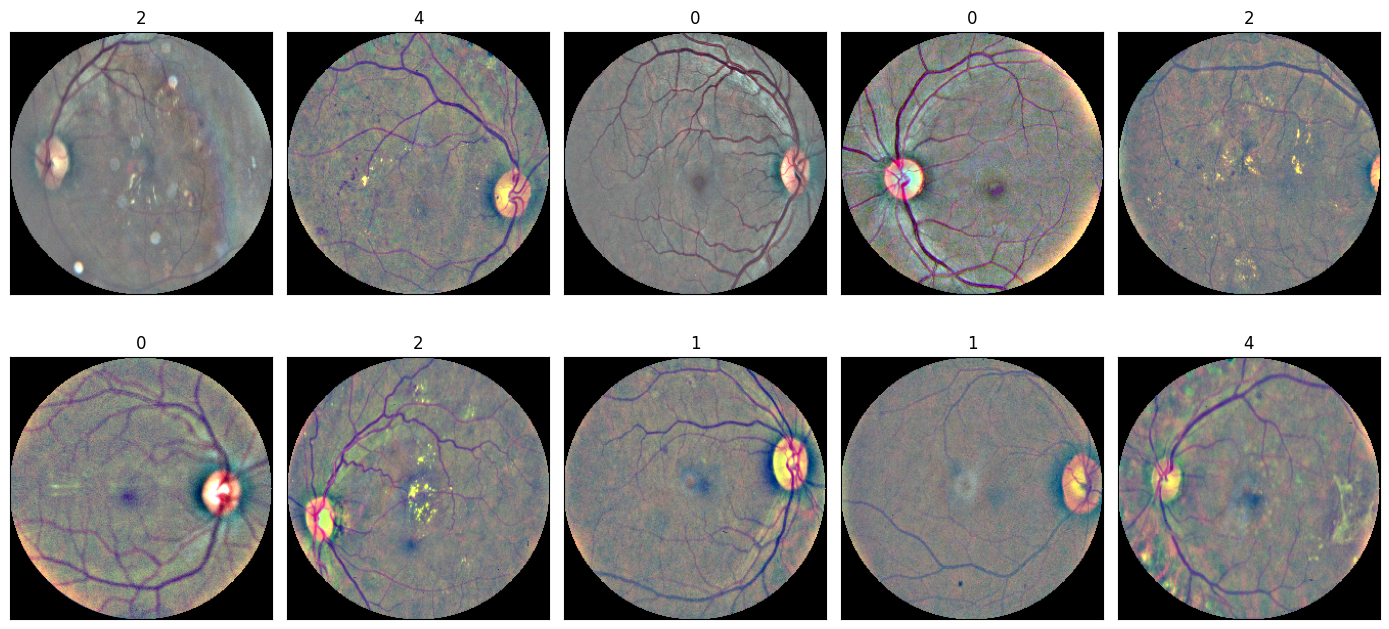

In [28]:


##### EXAMINE FIRST BATCH (TRAIN)

# get dataset
sample = EyeTrainData(
    data=aptos_train.iloc[0:10],
    directory='../input/aptos2019-blindness-detection/train_images',
    transform=train_trans
)
# sample_loader = DataLoader(dataset=sample, batch_size=10, shuffle=True, num_workers=0)
sample_loader = DataLoader(dataset=sample, batch_size=10, shuffle=True, num_workers=0)




# display images
# for batch_i, data in enumerate(sample_loader):

#     # extract data
#     inputs = data['image']
#     labels = data['label'].view(-1, 1)
    
#     # create plot
#     fig = plt.figure(figsize = (14, 7))
#     for i in range(len(labels)):
#         ax = fig.add_subplot(2, len(labels)/2, i + 1, xticks = [], yticks = [])     
#         plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
#         ax.set_title(labels.numpy()[i])

#     break


# Display images
for batch_i, data in enumerate(sample_loader):
    inputs = data['image']
    labels = data['label'].view(-1)

    fig = plt.figure(figsize=(14, 7))
    n_cols = len(labels) // 2 if len(labels) % 2 == 0 else (len(labels) // 2 + 1)
    for i in range(len(labels)):
        ax = fig.add_subplot(2, n_cols, i + 1, xticks=[], yticks=[])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))  # Convert from CHW to HWC
        ax.set_title(labels.numpy()[i])  # Display labels
    
    plt.tight_layout()
    plt.show()
    break  # Display only the first batch


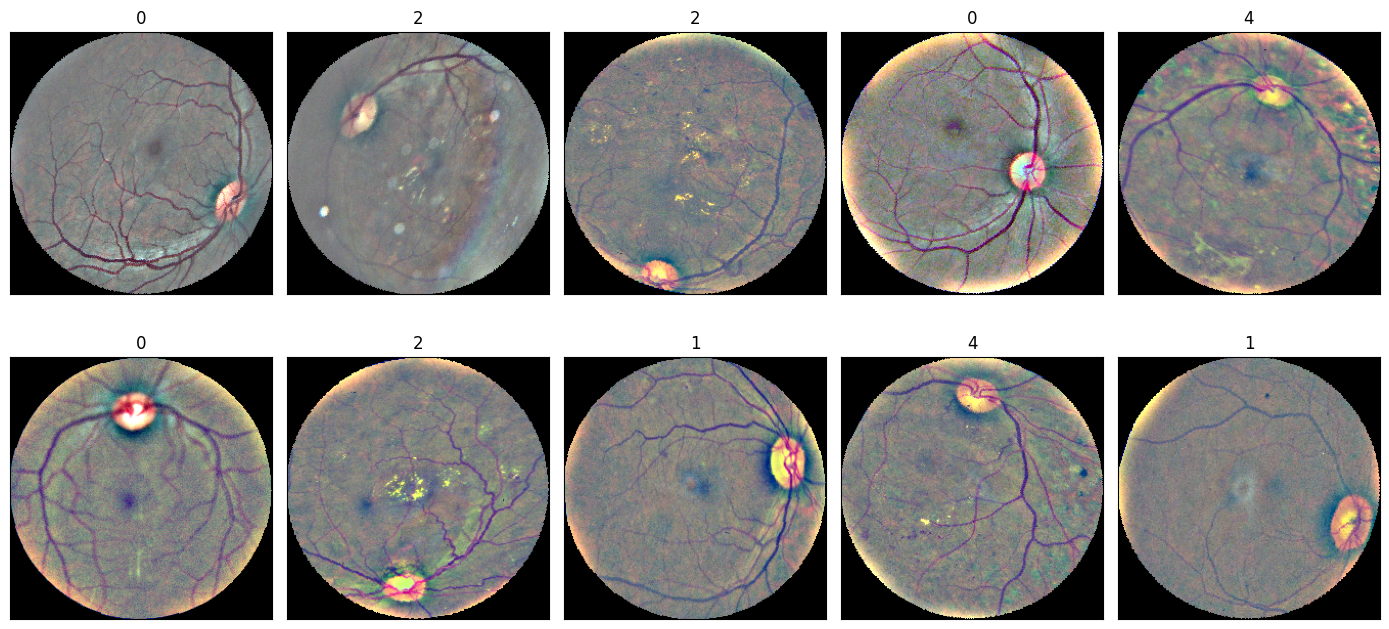

In [8]:
##### EXAMINE FIRST BATCH (TEST)

# get dataset
sample = EyeTestData(data        = test.iloc[0:10], 
                      directory  = '../input/aptos2019-blindness-detection/train_images',
                      transform  = train_trans)

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample, 
                                            batch_size  = batch_size, 
                                            shuffle     = True, 
                                            num_workers = 4)

# display images
for batch_i, data in enumerate(sample_loader):

    # extract data
    inputs = data['image']
    labels = data['label'].view(-1, 1)
    
    # create plot
    fig = plt.figure(figsize = (14, 7))
    for i in range(len(labels)):
        ax = fig.add_subplot(2, len(labels)/2, i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title(labels.numpy()[i])

    break

# MODEL SETUP

In [29]:
##### MODEL ARCHITECTURE

# model name
model_name = 'enet_b4'

# initialization function
def init_model(train = True):
    
    '''
    Initialize the model
    '''
    
    ### training mode
    if train == True:
        
        # load pre-trained model
        model = EfficientNet.from_pretrained('efficientnet-b4', num_classes = 5)
        
    ### inference mode
    if train == False:
        
        # load pre-trained model
        model = EfficientNet.from_name('efficientnet-b4')
        model._fc = nn.Linear(model._fc.in_features, 5)

        # freeze  layers
        for param in model.parameters():
            param.requires_grad = False
            
    ### return model
    return model


# check architecture
model = init_model()
print(model)

Loaded pretrained weights for efficientnet-b4
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, ke

# TRAINING

In [30]:
##### VALIDATION SETTINGS

# placeholders
oof_preds = np.zeros((len(test), 5))

# timer
cv_start = time.time()

In [31]:
##### PARAMETERS

# loss function
criterion = nn.CrossEntropyLoss()

# epochs
max_epochs = 15
early_stop = 5

# learning rates
eta = 1e-3

# scheduler
step  = 5
gamma = 0.5

In [ ]:
##### DATA PREPARATION

# load splits
data_train = train
data_valid = test

# create datasets
train_dataset = EyeTrainData(data      = data_train, 
                             directory = '../input/diabetic-retinopathy-resized/resized_train/resized_train',
                             transform = train_trans)
valid_dataset = EyeTestData(data       = data_valid, 
                            directory  = '../input/aptos2019-blindness-detection/train_images',
                            transform  = valid_trans)

# create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size  = batch_size, 
                                           shuffle     = True, 
                                           num_workers = 4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                           batch_size  = batch_size, 
                                           shuffle     = False, 
                                           num_workers = 4)


##### MODELING EPOCHS

# placeholders
val_kappas = []
val_losses = []
trn_losses = []
bad_epochs = 0

# initialize and send to GPU
model = init_model()
model = model.to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr = eta)
scheduler = lr_scheduler.StepLR(optimizer, step_size = step, gamma = gamma)

# training and validation loop
for epoch in range(max_epochs):

    ### PREPARATION

    # timer
    epoch_start = time.time()

    # reset losses
    trn_loss = 0.0
    val_loss = 0.0

    # placeholders
    fold_preds = np.zeros((len(data_valid), 5))


    ### TRAINING

    # switch regime
    model.train()

    # loop through batches
    for batch_i, data in enumerate(train_loader):

        # extract inputs and labels
        inputs = data['image']
        labels = data['label'].view(-1)
        inputs = inputs.to(device, dtype = torch.float)
        labels = labels.to(device, dtype = torch.long)
        optimizer.zero_grad()

        # forward and backward pass
        with torch.set_grad_enabled(True):
            preds = model(inputs)
            loss  = criterion(preds, labels)
            loss.backward()
            optimizer.step()

        # compute loss
        trn_loss += loss.item() * inputs.size(0)
        
        
    ### INFERENCE

    # switch regime
    model.eval()
    
    # loop through batches
    for batch_i, data in enumerate(valid_loader):
        
        # extract inputs and labels
        inputs = data['image']
        labels = data['label'].view(-1)
        inputs = inputs.to(device, dtype = torch.float)
        labels = labels.to(device, dtype = torch.long)

        # compute predictions
        with torch.set_grad_enabled(False):
            preds = model(inputs).detach()
            fold_preds[batch_i * batch_size:(batch_i + 1) * batch_size, :] = preds.cpu().numpy()

        # compute loss
        loss      = criterion(preds, labels)
        val_loss += loss.item() * inputs.size(0)
        
    # save predictions
    oof_preds = fold_preds

    # scheduler step
    scheduler.step()


    ### EVALUATION

    # evaluate performance
    fold_preds_round = fold_preds.argmax(axis = 1)
    val_kappa = metrics.cohen_kappa_score(data_valid['diagnosis'], fold_preds_round.astype('int'), weights = 'quadratic')

    # save perfoirmance values
    val_kappas.append(val_kappa)
    val_losses.append(val_loss / len(data_valid))
    trn_losses.append(trn_loss / len(data_train))


    ### EARLY STOPPING

    # display info
    print('- epoch {}/{} | lr = {} | trn_loss = {:.4f} | val_loss = {:.4f} | val_kappa = {:.4f} | {:.2f} min'.format(
        epoch + 1, max_epochs, scheduler.get_lr()[len(scheduler.get_lr()) - 1],
        trn_loss / len(data_train), val_loss / len(data_valid), val_kappa,
        (time.time() - epoch_start) / 60))

    # check if there is any improvement
    if epoch > 0:       
        if val_kappas[epoch] < val_kappas[epoch - bad_epochs - 1]:
            bad_epochs += 1
        else:
            bad_epochs = 0

    # save model weights if improvement
    if bad_epochs == 0:
        oof_preds_best = oof_preds.copy()
        torch.save(model.state_dict(), '../models/model_{}.bin'.format(model_name))

    # break if early stop
    if bad_epochs == early_stop:
        print('Early stopping. Best results: loss = {:.4f}, kappa = {:.4f} (epoch {})'.format(
            np.min(val_losses), val_kappas[np.argmin(val_losses)], np.argmin(val_losses) + 1))
        print('')
        break

    # break if max epochs
    if epoch == (max_epochs - 1):
        print('Did not met early stopping. Best results: loss = {:.4f}, kappa = {:.4f} (epoch {})'.format(
            np.min(val_losses), val_kappas[np.argmin(val_losses)], np.argmin(val_losses) + 1))
        print('')
        break


# load best predictions
oof_preds = oof_preds_best

# print performance
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

Loaded pretrained weights for efficientnet-b4


# EVALUATION

In [ ]:
##### PLOT LOSS AND KAPPA DYNAMICS

# plot size
fig = plt.figure(figsize = (15, 5))

# plot loss dynamics
plt.subplot(1, 2, 1)
plt.plot(trn_losses, 'red',   label = 'Training')
plt.plot(val_losses, 'green', label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plot kappa dynamics
plt.subplot(1, 2, 2)
plt.plot(val_kappas, 'blue', label = 'Kappa')
plt.xlabel('Epoch')
plt.ylabel('Kappa')
plt.legend()

# export plot
plt.savefig('../figures/fig_loss_pre_training.pdf')

In [ ]:
##### RECHECK PERFORMANCE

# rounding
oof_preds_round = oof_preds.argmax(axis = 1)
coef = [0.5, 1.5, 2.5, 3.5]
for i, pred in enumerate(oof_preds_round):
    if pred < coef[0]:
        oof_preds_round[i] = 0
    elif pred >= coef[0] and pred < coef[1]:
        oof_preds_round[i] = 1
    elif pred >= coef[1] and pred < coef[2]:
        oof_preds_round[i] = 2
    elif pred >= coef[2] and pred < coef[3]:
        oof_preds_round[i] = 3
    else:
        oof_preds_round[i] = 4

# compute kappa
oof_loss  = criterion(torch.tensor(oof_preds), torch.tensor(test['diagnosis']).view(-1).type(torch.long))
oof_kappa = metrics.cohen_kappa_score(test['diagnosis'], oof_preds_round.astype('int'), weights = 'quadratic')
print('OOF loss  = {:.4f}'.format(oof_loss))
print('OOF kappa = {:.4f}'.format(oof_kappa))

In [ ]:
##### CONFUSION MATRIX

# construct confusion matrix
cm = confusion_matrix(test['diagnosis'], oof_preds_round)
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
annot = np.around(cm, 2)

# plot matrix
fig, ax = plt.subplots(figsize = (8, 6))
sns.heatmap(cm, cmap = 'Blues', annot = annot, lw = 0.5)
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth')
ax.set_aspect('equal')
plt.savefig('../figures/fig_cm_pre_training.pdf')